## Feature Engineering
Once the data has been profiled, with any obvious defects having been addressed, the next activity is to potentially enhance the data's ability to produce effective machine learning models. The single greatest opportunity for doing so involves techniques that are aimed at enhancing the patterns inherent (or hidden), within the sample data. For example, a sample may include a datetime feature. In their raw form, datetime features may show little correlation to other features or the target.  However, dataparts like Year, Month, DayOfWeek, HourOfDay and whether a particular day is a WeekDay, WeekEndDay, or a Holiday may show significant correlation. Therefore, in such a case it would be advantageous to "extract" that information from the raw DateTime feature.    

#### Import Libraries

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import scipy.stats as stats
import matplotlib.pyplot as plt
from sklearn.datasets import load_boston
from sklearn.preprocessing import FunctionTransformer, OneHotEncoder, OrdinalEncoder, LabelEncoder
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#### Import the Data 

In [ ]:
ds = load_boston()
df = pd.DataFrame(ds.data, columns=ds.feature_names)
print(f"Shape: {df.shape[0]} Observations x {df.shape[1]} Features")

In [2]:
data_dir = os.path.join(os.getcwd(), 'Data')
source_data_file = 'titanic.csv';

data_file = os.path.join(data_dir, source_data_file)
df = pd.read_csv(data_file, header=0, index_col=0)

df.drop(['body', 'home.dest', 'boat', 'cabin'], axis=1, inplace=True)

df.dropna(subset=['fare','embarked','age'], inplace=True)

# Ensure the index values are: seed=1, increment=1
df.reset_index(drop=True, inplace=True)

print(f"Shape: {df.shape[0]} Observations x {df.shape[1]} Features")

Shape: 1043 Observations x 9 Features


#### Separate Numerical and Categorical Features

In [3]:
numerical_cols = [col for col in df.columns if df.dtypes[col] != 'O']
categorical_cols = [col for col in df.columns if col not in numerical_cols]

print(f"Features: {df[numerical_cols].shape[1]} Numerical, and {df[categorical_cols].shape[1]} Categorical")

Features: 5 Numerical, and 4 Categorical


### 1.0. Transforming Numerical Features
A number of machine learning algorithms, like Logistic Regression (for classification) and Linear Regression, assume that the features are Normally distributed; however, source data may not satisfy this assumption. Fortunately there are a number of mathematical transformations that can be used to engineer non-parametric features to conform to a parametric (normal or gaussian) distribution. What's more, these transformations often reviel linear relationships that may exist between those predictors (independent variables) and the response (dependend variable or Target). Ergo, these transformations may improve the efficacy of the resulting model. Among these mathematical transformations are the logarithm, reciprocal, power, square and cube root, Box-Cox, and Yeo-Johnson transformations. It is important to note that these tranformations should be applied to complete data; i.e., any missing data should have already either been excluded or imputed.

In [4]:
df[numerical_cols].isnull().sum().sort_values(ascending=True)

survived    0
age         0
sibsp       0
parch       0
fare        0
dtype: int64

#### 1.1 Logarithmic Transformation

In [5]:
def diagnostic_plots(df, variable):
    # function to plot a histogram and a Q-Q plot side by side, for a certain variable
    plt.figure(figsize=(15,6))
    plt.subplot(1, 2, 1)
    df[variable].hist(bins=30)
    plt.subplot(1, 2, 2)
    stats.probplot(df[variable], dist="norm", plot=plt)
    plt.show()

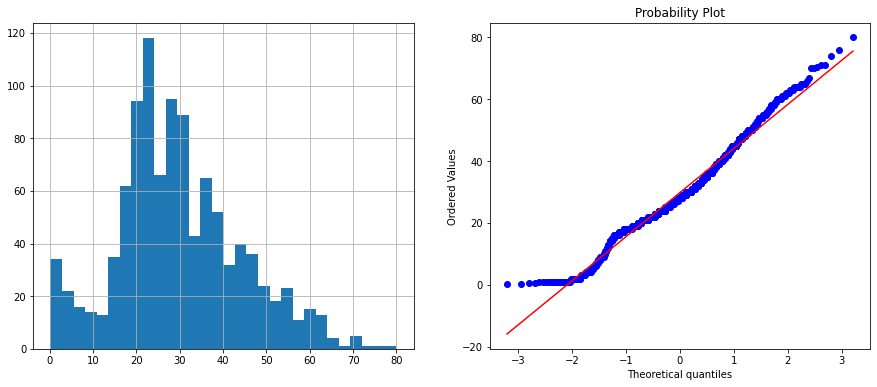

In [7]:
diagnostic_plots(df, 'age')

#### 1.1.1. Logarithmic Transformation Using NumPy

In [8]:
df_log = df[numerical_cols].copy()

In [10]:
df_log['age'] = np.log(df_log.age)

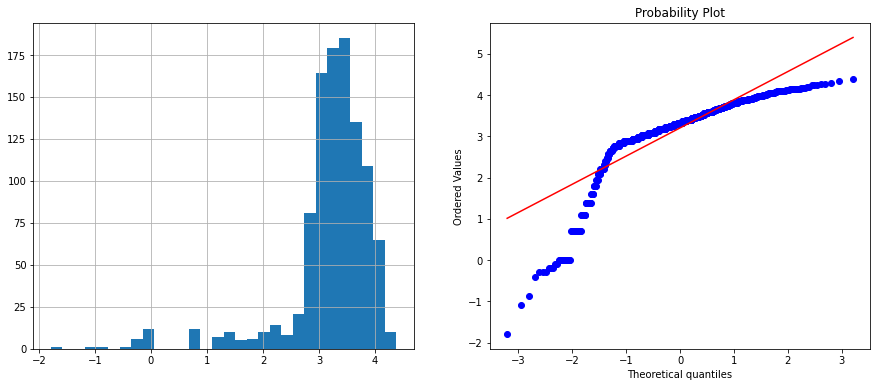

In [11]:
diagnostic_plots(df_log, 'age')

#### 1.1.2. Logarithmic Transformation Using Scikit-Learn

In [12]:
df_copy = df[numerical_cols].copy()

transformer = FunctionTransformer(np.log, validate=True)
df_trn = transformer.transform(df_copy)
df_trn = pd.DataFrame(df_trn, columns=numerical_cols)

/anaconda/envs/azureml_py38/lib/python3.8/site-packages/sklearn/preprocessing/_function_transformer.py:171: RuntimeWarning: divide by zero encountered in log
  return func(X, **(kw_args if kw_args else {}))


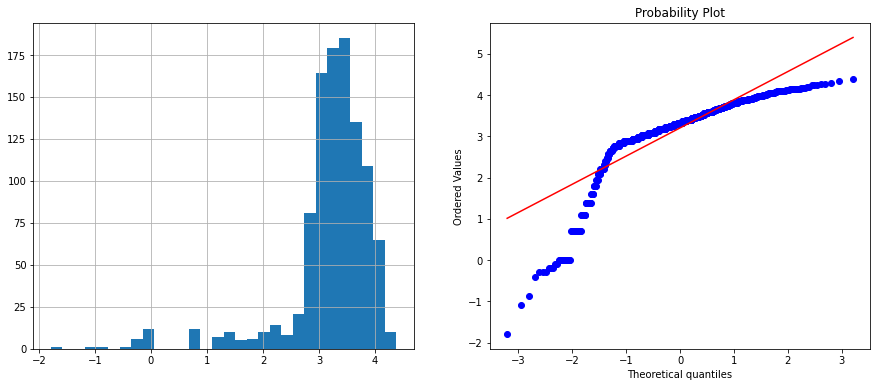

In [14]:
diagnostic_plots(df_log, 'age')

### 2.0 Scaling Numerical Features
Numerical features (variables) are those datum having continuous numeric values (e.g., float or decimal types).  As such, each numerical feature is likely to exhibit an unique range of values that may or may not contain both positive and negative values. Some machine learning algorithms are better equipt to cope with multiple features having different ranges than are others.  It is customary, if not altogether necessary, to transform each numerical feature in a collection of independent features so that they conform to a predetermined range (e.g., between 0 and 1, or having a mean of 0 (zero) and a standard deviation of 1 (one)).

In [29]:
df[categorical_cols].isnull().sum().sort_values(ascending=True)

name        0
sex         0
ticket      0
embarked    0
dtype: int64

### 3.0. Encoding Categorical Features
Categorical features (variables) are those datum having discrete values (rather than contiunous numerical values) where each unique value represents some member or level of the specified category. What's more, categorical features may reflect datum having a natural order (e.g., Size: Small, Medium or Large), or may exhibit no such natural ordering (e.g., Fruit: Apple, Orange, or Banana).  The former are designated **Ordinal** Categorical Variables whereas the latter are designated **Nominal** Categorical Variables. In any case, machine learning algorithms aren't typically well equipt to cope with text-based labels; therefore, it is both customary and necessary to translate these text-based labels into some form of numerical representation in order for machine learning algorithms to learn from them effectively.
#### 3.1. One-Hot Encoding
Sometimes called "dummy encoding", one-hot encoding is most appropriate for representing **nominal** categorical features because it is unable to denote any ordering of the values it represents. One-hot encoding transforms a categorical variable by creating a new group of binary variables where each member in the group represents each unique value (category) contained in the original variable. For each observation, only one of the new variables will contain the value 1 (one) as it corresponds to the value present in that observation while all other variables in the group will contain the value 0 (zero) to signify the absense of that value in the observation; hence, one is **"hot"** while the others are **not**.  For example, if a feature (variable) named "Color" contains the values "Red", "Green" and "Blue", then one-hot encoding would create three new features named "Red", "Green" and "Blue". Subsequently, where in a specific observation the feature named "Color" contains the value "Green", the new varable named "Green" would contain the value 1 (one) while the new variables named "Red" and "Blue" would both contain the value 0 (zero).

##### 3.1.1. One-Hot Encoding Using Pandas

In [28]:
df.sex.unique()

array(['female', 'male'], dtype=object)

In [26]:
ohe_sex = pd.get_dummies(df.sex, drop_first=False)
ohe_sex.head()

,female,male
0,1,0
1,0,1
2,1,0
3,0,1
4,1,0


##### Alternate: k-1 One-Hot Encoding
For the sake of reducing the dimensionality of the newly created group of binary variables, a categorical variable with *k* unique categories can be encoded using *k-1* binary variables. Extending our "Color" example, it is possible to accurately represent this feature using only 2 binary variables (e.g., Green and Blue). If the feature contained the value "Green" then the variable "Green" would be 1 (one) with the variable "Blue" being 0 (zero). If the feature contained the value "Blue" then the reverse would be true.  However, if the feature contained the value "Red" then both "Green" and "Blue" would contain the value 0 (zero).

In [27]:
k1_ohe_sex = pd.get_dummies(df.sex, drop_first=True)
k1_ohe_sex.head()

,male
0,0
1,1
2,0
3,1
4,0


##### 3.1.2. One-Hot Encoding Using Scikit-Learn

In [49]:
cats = df[categorical_cols].drop(['name', 'ticket'], axis=1)
cats.nunique()

sex         2
embarked    3
dtype: int64

In [53]:
oh_encoder = OneHotEncoder(categories='auto', sparse=False) # returns k dummies.
oh_encoder.fit(cats)

ohe_cats = oh_encoder.transform(cats)

In [54]:
pd.DataFrame(ohe_cats).head()

,0,1,2,3,4
0,1.0,0.0,0.0,0.0,1.0
1,0.0,1.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,1.0
3,0.0,1.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,1.0


##### Alternate: k-1 One-Hot Encoding

In [57]:
k1_oh_encoder = OneHotEncoder(categories='auto', sparse=False, drop='first') # returns k-1 dummies.
k1_oh_encoder.fit(cats)

k1_ohe_cats = k1_oh_encoder.transform(cats)

In [58]:
pd.DataFrame(k1_ohe_cats).head()

,0,1,2
0,0.0,0.0,1.0
1,1.0,0.0,1.0
2,0.0,0.0,1.0
3,1.0,0.0,1.0
4,0.0,0.0,1.0


##### 3.1.3. One-Hot Encoding of Most Frequent Categories
Since One-Hot Encoding represents each category that's contained by a categorical feature as a new feature, this encoding technique can quickly expand the dimensionality (i.e., the number of features) of a dataset if the feature being encoded is highly cardinal (i.e., has many unique values). This issue can be addressed by selectively discretizing those categories (values). The most frequently occurring categories can be represented by unique binary features per the customary one-hot encoding technique while those categories having few occurances can be grouped into a smaller number of additional binary features where each feature represents some logical range of values.

In [66]:
df.cabin.nunique()

AttributeError: 'DataFrame' object has no attribute 'cabin'

In [65]:
df.ticket.value_counts().sort_values(ascending=False)

CA 2144             8
347077              7
3101295             7
PC 17608            7
S.O.C. 14879        7
                   ..
349211              1
349230              1
237393              1
STON/O2. 3101282    1
343276              1
Name: ticket, Length: 730, dtype: int64

#### Ordinal Encoding

### 4.0. Engineering New Features